## APPROACH 2: Using Embeddings

In [0]:
# ============================================================================
# COMPLETE SETUP FOR DINOV3 ON DATABRICKS 15.4
# ============================================================================

print("="*60)
print("SETTING UP DINOV3 ENVIRONMENT")
print("="*60)

# Uninstall potentially conflicting packages
%pip uninstall -y transformers accelerate -q

# Install compatible versions
%pip install --upgrade \
    transformers==4.57.1 \
    accelerate==0.33.0 \
    albumentations==1.3.1 \
    opencv-python-headless==4.8.1.78 \
    openpyxl==3.1.2 \
    timm==0.9.12 \
    --quiet

print("\n✓ Installation complete!")
print("\n" + "="*60)
print("⚠️  RESTART KERNEL NOW!")
print("="*60)

SETTING UP DINOV3 ENVIRONMENT
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.

✓ Installation complete!

⚠️  RESTART KERNEL NOW!


In [0]:
%restart_python

Check CUDA memory and import libraries

In [0]:
import os
import re
import json
import random
import time
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler  # For mixed precision
from tqdm import tqdm
import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Transformers for DINOv3
from transformers import AutoImageProcessor, AutoModel

# Set random seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✓ Libraries imported")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ CUDA device: {torch.cuda.get_device_name(0)}")
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✓ GPU Memory: {total_mem:.2f} GB")

# ============================================================================
# GPU MEMORY CHECK
# ============================================================================

print("\n" + "="*60)
print("V100 16GB MEMORY CHECK")
print("="*60)

if torch.cuda.is_available():
    # Clear any existing cache
    torch.cuda.empty_cache()
    
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"\nTotal GPU Memory: {total_mem:.2f} GB")
    
    # Estimate memory requirements
    model_size_fp16 = 6.7e9 * 2 / 1024**3  # 6.7B params × 2 bytes (fp16)
    activation_size_batch8 = 8 * 224 * 224 * 3 * 4 / 1024**3  # Activations for batch=8
    classifier_size = 4.8e6 * 4 / 1024**3  # Classifier params
    buffer = 2.0  # Safety buffer
    
    estimated_need = model_size_fp16 + activation_size_batch8 + classifier_size + buffer
    
    print(f"\nEstimated Memory Needed (batch_size=8, fp16):")
    print(f"  DINOv3 Model: {model_size_fp16:.2f} GB")
    print(f"  Activations: {activation_size_batch8:.2f} GB")
    print(f"  Classifier: {classifier_size:.2f} GB")
    print(f"  Buffer: {buffer:.2f} GB")
    print(f"  Total: {estimated_need:.2f} GB")
    
    if total_mem >= estimated_need:
        print(f"\n✓ Should fit! ({total_mem - estimated_need:.2f} GB spare)")
    else:
        print(f"\n⚠️  Tight fit! ({estimated_need - total_mem:.2f} GB over)")
        print("  Will use aggressive memory optimizations")
else:
    print("❌ CUDA not available - cannot use DINOv3 on CPU!")

print("="*60)

2025-11-21 20:05:17.671853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ Libraries imported
✓ PyTorch version: 2.3.1+cu121
✓ CUDA available: True
✓ CUDA device: Tesla V100-PCIE-16GB
✓ GPU Memory: 15.77 GB

V100 16GB MEMORY CHECK

Total GPU Memory: 15.77 GB

Estimated Memory Needed (batch_size=8, fp16):
  DINOv3 Model: 12.48 GB
  Activations: 0.00 GB
  Classifier: 0.02 GB
  Buffer: 2.00 GB
  Total: 14.50 GB

✓ Should fit! (1.27 GB spare)



## MODULE 0: CONFIGURATION & DATA LOADING

In [0]:
# ================== CONFIGURATION ==================
class Config:
    # Base paths
    BASE_DBFS = "dbfs:/mnt/playbehavior/Fine_tuning"
    
    # Metadata paths
    METADATA_A = f"{BASE_DBFS}/Verified Lables/mmcows.xlsx"
    METADATA_B = f"{BASE_DBFS}/Verified Lables/PlayBehavior.xlsx"
    
    # Cropped images directories
    MMCOWS_CROPS_DBFS = f"{BASE_DBFS}/mmcows/visual_data/visual_data/images/Cropped Images"
    PLAYBEHAVIOR_CROPS_DBFS = f"{BASE_DBFS}/Playbehavior"
    
    # Behavior labels
    MMCOWS_LABELS = ["Drinking", "Feeding head up", "Feeding head down", "Lying", "Standing", "Walking"]
    PLAYBEHAVIOR_LABELS = ["gallop", "leap", "frontal_pushing"]
    ALL_LABELS = MMCOWS_LABELS + PLAYBEHAVIOR_LABELS
    
    # Dataset parameters
    TRAIN_SAMPLES_PER_LABEL = 300
    AUGMENTED_SAMPLES_PER_LABEL = 900
    IMAGE_SIZE = 224
    
    # Verification priority
    VERIFICATION_PRIORITY = {1: 0, 3: 1, 2: 2}
    
    # Output paths for processed datasets
    OUTPUT_BASE = f"{BASE_DBFS}/Processed_Datasets"
    TRAIN_DATASET_PATH = f"{OUTPUT_BASE}/train_dataset.csv"
    TEST_MMCOWS_DATASET_PATH = f"{OUTPUT_BASE}/test_mmcows_dataset.csv"
    TEST_PLAYBEHAVIOR_DATASET_PATH = f"{OUTPUT_BASE}/test_playbehavior_dataset.csv"

# ================== UTILITY FUNCTIONS ==================
def dbfs_to_local(path: str) -> str:
    """Convert DBFS path to local /dbfs path"""
    if path.startswith("dbfs:/"):
        return "/dbfs" + path[5:]
    return path

def local_to_dbfs(path: str) -> str:
    """Convert local /dbfs path to DBFS URI"""
    if path.startswith("/dbfs/"):
        return "dbfs:" + path[5:]
    return path

def ensure_local_path(path: str) -> str:
    """Ensure path is in local /dbfs format"""
    if pd.isna(path) or not isinstance(path, str):
        return ""
    return dbfs_to_local(path)

def check_image_exists(path: str) -> bool:
    """Check if image file exists and is readable"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return False
    try:
        img = Image.open(local_path)
        img.verify()
        return True
    except:
        return False

def load_image_cv2(path: str) -> Optional[np.ndarray]:
    """Load image using OpenCV"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return None
    img = cv2.imread(local_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_image_pil(path: str) -> Optional[Image.Image]:
    """Load image using PIL"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return None
    try:
        return Image.open(local_path).convert('RGB')
    except:
        return None

print("✓ Configuration and utilities loaded")
print(f"  - Training samples per label: {Config.TRAIN_SAMPLES_PER_LABEL}")
print(f"  - Target augmented samples: {Config.AUGMENTED_SAMPLES_PER_LABEL}")
print(f"  - Total labels: {len(Config.ALL_LABELS)}")

# ================== RELOAD DATASETS ==================
print("="*60)
print("RELOADING ALL SAVED DATASETS")
print("="*60)

# Check if datasets exist
train_csv_path = dbfs_to_local(Config.TRAIN_DATASET_PATH)
mmcows_test_csv_path = dbfs_to_local(Config.TEST_MMCOWS_DATASET_PATH)
playbehavior_test_csv_path = dbfs_to_local(Config.TEST_PLAYBEHAVIOR_DATASET_PATH)

datasets_exist = {
    'train': os.path.exists(train_csv_path),
    'mmcows_test': os.path.exists(mmcows_test_csv_path),
    'playbehavior_test': os.path.exists(playbehavior_test_csv_path)
}

print("\n📂 Dataset Files Status:")
for name, exists in datasets_exist.items():
    status = "✓ Found" if exists else "✗ Missing"
    print(f"  {name:20s}: {status}")

if not all(datasets_exist.values()):
    raise FileNotFoundError("Some dataset files are missing! Please rerun Modules 1-4")

print("\n✓ All dataset files found! Loading...")

# Load Training Dataset
print("\n[1/3] Loading training dataset...")
train_df = pd.read_csv(train_csv_path)
print(f"  ✓ Loaded: {len(train_df):,} samples")
print(f"    - Labels: {sorted(train_df['label'].unique())}")
print(f"    - Sources: {train_df['source'].unique().tolist()}")

# Load MMcows Test Dataset
print("\n[2/3] Loading MMcows test dataset...")
mmcows_test_df = pd.read_csv(mmcows_test_csv_path)
print(f"  ✓ Loaded: {len(mmcows_test_df):,} samples")
print(f"    - Labels: {sorted(mmcows_test_df['label'].unique())}")

# Load PlayBehavior Test Dataset
print("\n[3/3] Loading PlayBehavior test dataset...")
playbehavior_test_df = pd.read_csv(playbehavior_test_csv_path)
print(f"  ✓ Loaded: {len(playbehavior_test_df):,} samples")
print(f"    - Labels: {sorted(playbehavior_test_df['label'].unique())}")

# Combine test datasets
combined_test_df = pd.concat([mmcows_test_df, playbehavior_test_df], ignore_index=True)
print(f"\n✓ Combined test dataset: {len(combined_test_df):,} samples")

print("\n" + "="*60)

# ================== QUICK VALIDATION ==================
print("="*60)
print("QUICK VALIDATION")
print("="*60)

train_paths = set(train_df['image_path'].values)
test_paths = set(combined_test_df['image_path'].values)
overlap = train_paths & test_paths

print(f"\n🔍 Train/Test Overlap Check:")
print(f"  - Training paths: {len(train_paths):,}")
print(f"  - Test paths: {len(test_paths):,}")
print(f"  - Overlap: {len(overlap):,}")

if len(overlap) == 0:
    print("  ✓ PASS: No overlap between train and test")
else:
    print("  ✗ FAIL: Found overlapping samples!")
    print(f"    First few overlaps: {list(overlap)[:5]}")

# Check label consistency
train_labels = set(train_df['label'].unique())
test_labels = set(combined_test_df['label'].unique())

print(f"\n🏷️  Label Consistency Check:")
print(f"  - Training labels: {len(train_labels)}")
print(f"  - Test labels: {len(test_labels)}")

if train_labels == test_labels:
    print("  ✓ PASS: Same labels in train and test")
else:
    missing_in_test = train_labels - test_labels
    missing_in_train = test_labels - train_labels
    if missing_in_test:
        print(f"  ⚠️  Labels in train but not test: {missing_in_test}")
    if missing_in_train:
        print(f"  ⚠️  Labels in test but not train: {missing_in_train}")

print("\n" + "="*60)
print("✓ VALIDATION COMPLETE")
print("="*60)

# ================== CREATE TRAIN/VAL SPLIT (80/20) ==================
print("="*60)
print("CREATING TRAIN/VALIDATION SPLIT (80/20)")
print("="*60)

from sklearn.model_selection import train_test_split

# Stratified split to maintain class balance
train_split_df, val_split_df = train_test_split(
    train_df,
    test_size=0.2,  # 20% for validation
    stratify=train_df['label'],
    random_state=42
)

print(f"Original training set: {len(train_df)} samples")
print(f"  → Train split: {len(train_split_df)} samples (240 per class)")
print(f"  → Val split: {len(val_split_df)} samples (60 per class)")

print("\nTrain split distribution:")
for label, count in train_split_df['label'].value_counts().sort_index().items():
    print(f"  {label:25s}: {count:3d}")

print("\nValidation split distribution:")
for label, count in val_split_df['label'].value_counts().sort_index().items():
    print(f"  {label:25s}: {count:3d}")

# Save splits to CSV
train_split_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/train_split.csv")
val_split_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/val_split.csv")

train_split_df.to_csv(train_split_path, index=False)
val_split_df.to_csv(val_split_path, index=False)

print(f"\n✓ Saved train split: {local_to_dbfs(train_split_path)}")
print(f"✓ Saved val split: {local_to_dbfs(val_split_path)}")
print("="*60)

✓ Configuration and utilities loaded
  - Training samples per label: 300
  - Target augmented samples: 900
  - Total labels: 9
RELOADING ALL SAVED DATASETS

📂 Dataset Files Status:
  train               : ✓ Found
  mmcows_test         : ✓ Found
  playbehavior_test   : ✓ Found

✓ All dataset files found! Loading...

[1/3] Loading training dataset...
  ✓ Loaded: 2,700 samples
    - Labels: ['Drinking', 'Feeding head down', 'Feeding head up', 'Lying', 'Standing', 'Walking', 'frontal_pushing', 'gallop', 'leap']
    - Sources: ['mmcows', 'playbehavior']

[2/3] Loading MMcows test dataset...
  ✓ Loaded: 209,881 samples
    - Labels: ['Drinking', 'Feeding head down', 'Feeding head up', 'Lying', 'Standing', 'Walking']

[3/3] Loading PlayBehavior test dataset...
  ✓ Loaded: 1,919 samples
    - Labels: ['frontal_pushing', 'gallop', 'leap']

✓ Combined test dataset: 211,800 samples

QUICK VALIDATION

🔍 Train/Test Overlap Check:
  - Training paths: 2,700
  - Test paths: 211,800
  - Overlap: 0
  ✓ 

## MODULE 5: AUGMENTATION PIPELINE

In [0]:
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from typing import Optional, Tuple, Dict, Any

class AugmentationPipeline:
    """
    Comprehensive augmentation pipeline for cow behavior images
    Uses albumentations for diverse and efficient augmentation
    """
    
    def __init__(self, 
                 image_size: int = 224,
                 mode: str = 'train',
                 augmentation_strength: str = 'medium'):
        """
        Args:
            image_size: Target image size (default 224 for most models)
            mode: 'train', 'val', or 'test'
            augmentation_strength: 'light', 'medium', or 'heavy'
        """
        self.image_size = image_size
        self.mode = mode
        self.augmentation_strength = augmentation_strength
        
        # Build augmentation pipeline based on mode
        if mode == 'train':
            self.transform = self._build_train_transform()
        else:
            self.transform = self._build_eval_transform()
    
    def _build_train_transform(self) -> A.Compose:
        """Build training augmentation pipeline"""
        
        # Define augmentation strength parameters
        if self.augmentation_strength == 'light':
            brightness_limit = 0.1
            contrast_limit = 0.1
            rotation_limit = 10
            scale_range = (0.9, 1.1)
        elif self.augmentation_strength == 'medium':
            brightness_limit = 0.2
            contrast_limit = 0.2
            rotation_limit = 15
            scale_range = (0.8, 1.2)
        else:  # heavy
            brightness_limit = 0.3
            contrast_limit = 0.3
            rotation_limit = 20
            scale_range = (0.7, 1.3)
        
        transform = A.Compose([
            # Geometric transformations
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=rotation_limit, p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=(scale_range[0]-1, scale_range[1]-1),
                rotate_limit=rotation_limit,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                p=0.5
            ),
            A.Perspective(scale=(0.05, 0.1), p=0.3),
            
            # Color transformations
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=brightness_limit,
                    contrast_limit=contrast_limit,
                    p=1.0
                ),
                A.HueSaturationValue(
                    hue_shift_limit=10,
                    sat_shift_limit=20,
                    val_shift_limit=20,
                    p=1.0
                ),
                A.ColorJitter(
                    brightness=brightness_limit,
                    contrast=contrast_limit,
                    saturation=0.2,
                    hue=0.1,
                    p=1.0
                ),
            ], p=0.8),
            
            # Noise and blur
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
                A.GaussianBlur(blur_limit=(3, 5), p=1.0),
                A.MotionBlur(blur_limit=5, p=1.0),
            ], p=0.3),
            
            # Advanced augmentations
            A.CoarseDropout(
                max_holes=8,
                max_height=int(0.1 * self.image_size),
                max_width=int(0.1 * self.image_size),
                min_holes=1,
                fill_value=0,
                p=0.2
            ),
            
            # Resize and normalize
            A.Resize(self.image_size, self.image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet stats
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        
        return transform
    
    def _build_eval_transform(self) -> A.Compose:
        """Build evaluation (validation/test) transform - no augmentation"""
        transform = A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        
        return transform
    
    def __call__(self, image: np.ndarray) -> torch.Tensor:
        """
        Apply transformation to image
        
        Args:
            image: numpy array in RGB format (H, W, C)
        
        Returns:
            Transformed image as PyTorch tensor
        """
        if not isinstance(image, np.ndarray):
            raise TypeError(f"Expected numpy array, got {type(image)}")
        
        # Ensure image is in correct format
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
        
        # Apply transformations
        transformed = self.transform(image=image)
        return transformed['image']
    
    def get_params_summary(self) -> Dict[str, Any]:
        """Get summary of augmentation parameters"""
        return {
            'mode': self.mode,
            'image_size': self.image_size,
            'augmentation_strength': self.augmentation_strength,
            'num_transforms': len(self.transform.transforms) if hasattr(self.transform, 'transforms') else 0
        }


print("="*60)
print("AUGMENTATION PIPELINE")
print("="*60)

# Create pipelines for different modes
train_aug = AugmentationPipeline(image_size=224, mode='train', augmentation_strength='medium')
test_aug = AugmentationPipeline(image_size=224, mode='test')

print("\n✓ Training augmentation pipeline:")
print(f"  - Image size: {train_aug.image_size}")
print(f"  - Mode: {train_aug.mode}")
print(f"  - Strength: {train_aug.augmentation_strength}")
print(f"  - Transforms: {len(train_aug.transform.transforms)}")

print("\n✓ Test/validation pipeline:")
print(f"  - Image size: {test_aug.image_size}")
print(f"  - Mode: {test_aug.mode}")
print(f"  - Transforms: {len(test_aug.transform.transforms)} (resize + normalize only)")

print("\n" + "="*60)
print("Ready for dataset integration!")
print("="*60)



AUGMENTATION PIPELINE

✓ Training augmentation pipeline:
  - Image size: 224
  - Mode: train
  - Strength: medium
  - Transforms: 10

✓ Test/validation pipeline:
  - Image size: 224
  - Mode: test
  - Transforms: 3 (resize + normalize only)

Ready for dataset integration!


## MODULE 6: PYTORCH DATASET & DATALOADER (UPDATED FOR 3× AUGMENTATION)

In [0]:

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from typing import Optional, Callable, Dict, Tuple
import pandas as pd
from collections import Counter

class CowBehaviorDataset(Dataset):
    """
    Dataset with on-the-fly 3× augmentation for training:
    - Returns 3 versions: original + 2 augmented
    - Effectively 3× the dataset size
    """
    
    def __init__(self,
                 metadata_df: pd.DataFrame,
                 transform: Optional[Callable] = None,
                 image_size: int = 224,
                 mode: str = 'train',
                 augmentation_strength: str = 'medium',
                 label_to_idx: Optional[Dict[str, int]] = None,
                 augmentation_multiplier: int = 3):
        """
        Args:
            augmentation_multiplier: Number of versions per image (1=original only, 3=original+2 augmented)
        """
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.image_size = image_size
        self.mode = mode
        # self.augmentation_multiplier = augmentation_multiplier if mode == 'train' else 1
        self.augmentation_multiplier = augmentation_multiplier

        # Create label mapping
        if label_to_idx is None:
            unique_labels = sorted(self.metadata_df['label'].unique())
            self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        else:
            self.label_to_idx = label_to_idx
        
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)
        
        # # Setup transforms
        # # For training: need both non-augmented (for original) and augmented transforms
        # if mode == 'train':
        #     self.transform_original = AugmentationPipeline(
        #         image_size=image_size,
        #         mode='test',  # No augmentation for "original" version
        #         augmentation_strength=augmentation_strength
        #     )
        #     self.transform_augmented = AugmentationPipeline(
        #         image_size=image_size,
        #         mode='train',  # With augmentation
        #         augmentation_strength=augmentation_strength
        #     )
        # else:
        #     # Val/test: no augmentation
        #     if transform is not None:
        #         self.transform_original = transform
        #     else:
        #         self.transform_original = AugmentationPipeline(
        #             image_size=image_size,
        #             mode='test'
        #         )
                
        # Setup transforms
        # For training or augmented validation:
        if mode == 'train' or (mode == 'val' and self.augmentation_multiplier > 1):
            self.transform_original = AugmentationPipeline(
                image_size=image_size,
                mode='test',  # No augmentation for "original" version
                augmentation_strength=augmentation_strength
            )
            self.transform_augmented = AugmentationPipeline(
                image_size=image_size,
                mode='train',  # With augmentation
                augmentation_strength=augmentation_strength
            )
        else:
            # Standard val/test: no augmentation
            if transform is not None:
                self.transform_original = transform
            else:
                self.transform_original = AugmentationPipeline(
                    image_size=image_size,
                    mode='test'
                )
        
        # Cache for failed image loads
        self._failed_indices = set()
        
        print(f"[{mode.upper()} Dataset] Initialized")
        print(f"  - Physical samples: {len(self.metadata_df)}")
        print(f"  - Augmentation multiplier: {self.augmentation_multiplier}×")
        print(f"  - Effective samples: {len(self)} (what DataLoader sees)")
        print(f"  - Number of classes: {self.num_classes}")
    
    def __len__(self) -> int:
        """
        Return effective dataset size (physical samples × augmentation multiplier)
        This makes DataLoader iterate through all augmented versions
        """
        return len(self.metadata_df) * self.augmentation_multiplier
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, Dict]:
        """
        Get item by index
        
        For training with augmentation_multiplier=3:
        - idx 0, 1, 2 → same image (idx 0), different augmentations
        - idx 3, 4, 5 → same image (idx 1), different augmentations
        
        Returns:
            image: Transformed image tensor (C, H, W)
            label: Label index
            metadata: Dictionary with additional info
        """
        # Map augmented index to physical sample index
        physical_idx = idx // self.augmentation_multiplier
        augmentation_idx = idx % self.augmentation_multiplier
        
        if physical_idx in self._failed_indices:
            # Return a random valid index if this one previously failed
            new_idx = np.random.randint(0, len(self))
            return self.__getitem__(new_idx)
        
        try:
            row = self.metadata_df.iloc[physical_idx]
            
            # Load image
            image_path = row['image_path']
            image = load_image_cv2(image_path)  # Returns RGB numpy array
            
            if image is None:
                self._failed_indices.add(physical_idx)
                # Fallback to random valid sample
                return self.__getitem__(np.random.randint(0, len(self)))
            
            # Get label
            label_str = row['label']
            label_idx = self.label_to_idx[label_str]
            
            # Apply transforms based on augmentation index
            # if self.mode == 'train':
            #     if augmentation_idx == 0:
            #         # Original (no augmentation)
            #         image_tensor = self.transform_original(image)
            #     else:
            #         # Augmented versions
            #         image_tensor = self.transform_augmented(image)
            # else:
            #     # Val/test: always use original transform
            #     image_tensor = self.transform_original(image)
            
            # Apply transforms based on augmentation index
            if self.mode == 'train' or (self.mode == 'val' and self.augmentation_multiplier > 1):
                if augmentation_idx == 0:
                    # Original (no augmentation)
                    image_tensor = self.transform_original(image)
                else:
                    # Augmented versions
                    image_tensor = self.transform_augmented(image)
            else:
                # Standard Val/test: always use original transform
                image_tensor = self.transform_original(image)

            # Metadata
            metadata = {
                'idx': idx,
                'physical_idx': physical_idx,
                'augmentation_idx': augmentation_idx,
                'image_path': image_path,
                'label_str': label_str,
                'label_idx': label_idx,
                'source': row.get('source', 'unknown'),
                'cow_id': row.get('cow_id', -1),
            }
            
            return image_tensor, label_idx, metadata
        
        except Exception as e:
            print(f"Error loading sample {idx} (physical {physical_idx}): {e}")
            self._failed_indices.add(physical_idx)
            # Return random valid sample
            return self.__getitem__(np.random.randint(0, len(self)))
    
    def get_label_distribution(self) -> Dict[str, int]:
        """Get distribution of labels in physical dataset"""
        return dict(Counter(self.metadata_df['label']))
    
    def get_class_weights(self) -> torch.Tensor:
        """
        Calculate class weights for balanced training
        Based on physical dataset (not augmented count)
        """
        label_counts = self.metadata_df['label'].value_counts()
        total_samples = len(self.metadata_df)
        
        # Calculate weights (inverse frequency)
        weights = []
        for label in sorted(self.label_to_idx.keys()):
            count = label_counts.get(label, 1)
            weight = total_samples / (len(label_counts) * count)
            weights.append(weight)
        
        return torch.FloatTensor(weights)
    
    def get_sample_weights(self) -> torch.Tensor:
        """
        Get per-sample weights for WeightedRandomSampler
        Returns weights for EFFECTIVE dataset size (with augmentation)
        """
        class_weights = self.get_class_weights()
        sample_weights = []
        
        for _ in range(self.augmentation_multiplier):
            for _, row in self.metadata_df.iterrows():
                label_idx = self.label_to_idx[row['label']]
                sample_weights.append(class_weights[label_idx].item())
        
        return torch.FloatTensor(sample_weights)


def create_dataloaders(train_df: pd.DataFrame,
                       val_df: pd.DataFrame,
                       test_df: Optional[pd.DataFrame] = None,
                       batch_size: int = 32,
                       num_workers: int = 4,
                       image_size: int = 224,
                       use_weighted_sampling: bool = False,
                       augmentation_strength: str = 'medium',
                       augmentation_multiplier: int = 3, val_augmentation_multiplier: int = 1) -> Dict[str, DataLoader]:
    """
    Create PyTorch DataLoaders with 3× augmentation for training
    
    Args:
        train_df: Training metadata DataFrame (will be augmented 3×)
        val_df: Validation metadata DataFrame (no augmentation)
        test_df: Test metadata DataFrame (optional, no augmentation)
        augmentation_multiplier: Number of versions per training image (3 = 900 total)
    """
    
    # Create label mapping from all data
    all_labels = set(train_df['label'].unique())
    all_labels.update(val_df['label'].unique())
    if test_df is not None:
        all_labels.update(test_df['label'].unique())
    
    label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
    
    # Create training dataset (with 3× augmentation)
    train_dataset = CowBehaviorDataset(
        train_df,
        image_size=image_size,
        mode='train',
        augmentation_strength=augmentation_strength,
        label_to_idx=label_to_idx,
        augmentation_multiplier=augmentation_multiplier
    )
    
    # Setup sampler for training
    if use_weighted_sampling:
        sample_weights = train_dataset.get_sample_weights()
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        shuffle = False
        print("✓ Using WeightedRandomSampler for balanced training")
    else:
        sampler = None
        shuffle = True
    
    # Training dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    dataloaders = {'train': train_loader}
    
    # # Validation dataloader (NO augmentation)
    # val_dataset = CowBehaviorDataset(
    #     val_df,
    #     image_size=image_size,
    #     mode='val',
    #     label_to_idx=label_to_idx,
    #     augmentation_multiplier=1
    # )
    # Validation dataloader (NOW with controllable augmentation)
    val_dataset = CowBehaviorDataset(
        val_df,
        image_size=image_size,
        mode='val',
        augmentation_strength=augmentation_strength, # Pass strength
        label_to_idx=label_to_idx,
        augmentation_multiplier=val_augmentation_multiplier # Use new param
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    dataloaders['val'] = val_loader
    
    # Test dataloader (if provided)
    if test_df is not None:
        test_dataset = CowBehaviorDataset(
            test_df,
            image_size=image_size,
            mode='test',
            label_to_idx=label_to_idx,
            augmentation_multiplier=1
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
        dataloaders['test'] = test_loader
    
    return dataloaders


print("="*60)
print("✓ UPDATED DATASET CLASS (3× AUGMENTATION)")
print("="*60)
print("Changes:")
print("  - __len__() returns physical_samples × augmentation_multiplier")
print("  - __getitem__() returns original (idx 0, 3, 6...) or augmented (idx 1,2,4,5...)")
print("  - Training sees 900 samples per class (300 physical × 3)")
print("="*60)

✓ UPDATED DATASET CLASS (3× AUGMENTATION)
Changes:
  - __len__() returns physical_samples × augmentation_multiplier
  - __getitem__() returns original (idx 0, 3, 6...) or augmented (idx 1,2,4,5...)
  - Training sees 900 samples per class (300 physical × 3)


## MODULE 7: VALIDATION & VISUALIZATION

In [0]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from typing import List
import torch

class DatasetValidator:
    """
    Validate and visualize datasets before training
    """
    
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        self.train_df = train_df
        self.test_df = test_df
    
    def print_statistics(self):
        """Print comprehensive dataset statistics"""
        print("="*60)
        print("DATASET STATISTICS")
        print("="*60)
        
        print("\n📊 TRAINING SET")
        print("-" * 60)
        print(f"Total samples: {len(self.train_df)}")
        print(f"Number of labels: {self.train_df['label'].nunique()}")
        print(f"Sources: {self.train_df['source'].unique()}")
        
        print("\nSamples per label:")
        for label, count in self.train_df['label'].value_counts().sort_index().items():
            print(f"  {label:25s}: {count:4d}")
        
        print("\nSamples per source:")
        for source, count in self.train_df['source'].value_counts().items():
            print(f"  {source:15s}: {count:4d}")
        
        if 'Verification' in self.train_df.columns:
            print("\nVerification distribution:")
            for ver, count in self.train_df['Verification'].value_counts().sort_index().items():
                pct = 100 * count / len(self.train_df)
                print(f"  Verification {ver}: {count:4d} ({pct:.1f}%)")
        
        print("\n" + "="*60)
        print("📊 TEST SET")
        print("-" * 60)
        print(f"Total samples: {len(self.test_df)}")
        print(f"Number of labels: {self.test_df['label'].nunique()}")
        print(f"Sources: {self.test_df['source'].unique()}")
        
        print("\nSamples per label:")
        for label, count in self.test_df['label'].value_counts().sort_index().items():
            train_count = len(self.train_df[self.train_df['label'] == label])
            ratio = count / train_count if train_count > 0 else 0
            print(f"  {label:25s}: {count:6d} (train:test = 1:{ratio:.1f})")
        
        print("\nSamples per source:")
        for source, count in self.test_df['source'].value_counts().items():
            print(f"  {source:15s}: {count:6d}")
    
    def plot_label_distribution(self, figsize=(14, 6)):
        """Plot label distribution for train and test sets"""
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Training set
        train_counts = self.train_df['label'].value_counts().sort_index()
        axes[0].bar(range(len(train_counts)), train_counts.values, color='steelblue', alpha=0.7)
        axes[0].set_xticks(range(len(train_counts)))
        axes[0].set_xticklabels(train_counts.index, rotation=45, ha='right')
        axes[0].set_ylabel('Count')
        axes[0].set_title(f'Training Set Distribution\n(Total: {len(self.train_df)} samples)')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Test set
        test_counts = self.test_df['label'].value_counts().sort_index()
        axes[1].bar(range(len(test_counts)), test_counts.values, color='coral', alpha=0.7)
        axes[1].set_xticks(range(len(test_counts)))
        axes[1].set_xticklabels(test_counts.index, rotation=45, ha='right')
        axes[1].set_ylabel('Count')
        axes[1].set_title(f'Test Set Distribution\n(Total: {len(self.test_df)} samples)')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def check_data_integrity(self) -> Dict[str, bool]:
        """Check data integrity and return status"""
        checks = {}
        
        # Check 1: No overlap between train and test
        train_paths = set(self.train_df['image_path'])
        test_paths = set(self.test_df['image_path'])
        overlap = train_paths & test_paths
        checks['no_overlap'] = len(overlap) == 0
        
        if not checks['no_overlap']:
            print(f"⚠️  WARNING: {len(overlap)} samples appear in both train and test!")
        else:
            print("✓ No overlap between train and test sets")
        
        # Check 2: All labels present in both sets
        train_labels = set(self.train_df['label'])
        test_labels = set(self.test_df['label'])
        checks['labels_match'] = train_labels == test_labels
        
        if not checks['labels_match']:
            missing_in_test = train_labels - test_labels
            missing_in_train = test_labels - train_labels
            if missing_in_test:
                print(f"⚠️  WARNING: Labels in train but not test: {missing_in_test}")
            if missing_in_train:
                print(f"⚠️  WARNING: Labels in test but not train: {missing_in_train}")
        else:
            print("✓ All labels present in both train and test sets")
        
        # Check 3: Reasonable train/test split ratios
        checks['reasonable_splits'] = True
        for label in train_labels:
            train_count = len(self.train_df[self.train_df['label'] == label])
            test_count = len(self.test_df[self.test_df['label'] == label])
            if test_count == 0:
                print(f"⚠️  WARNING: Label '{label}' has no test samples!")
                checks['reasonable_splits'] = False
        
        if checks['reasonable_splits']:
            print("✓ All labels have test samples")
        
        return checks


def visualize_augmentations(dataset: CowBehaviorDataset, 
                            num_samples: int = 3,
                            num_augmentations: int = 5,
                            figsize=(15, 10)):
    """
    Visualize augmentation effects on random samples
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(num_samples, num_augmentations + 1, figure=fig)
    
    # Denormalize function
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)
        return tensor.permute(1, 2, 0).numpy()
    
    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Get original image (without augmentation)
        row = dataset.metadata_df.iloc[idx]
        original_img = load_image_cv2(row['image_path'])
        label = row['label']
        
        # Show original
        ax = fig.add_subplot(gs[i, 0])
        ax.imshow(original_img)
        ax.set_title(f'Original\n{label}', fontsize=10)
        ax.axis('off')
        
        # Show augmented versions
        for j in range(num_augmentations):
            img_tensor, _, _ = dataset[idx]
            img_np = denormalize(img_tensor)
            
            ax = fig.add_subplot(gs[i, j + 1])
            ax.imshow(img_np)
            ax.set_title(f'Aug {j+1}', fontsize=10)
            ax.axis('off')
    
    plt.suptitle('Augmentation Visualization (Original + 5 Random Augmentations)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def test_dataloader_speed(dataloader: DataLoader, num_batches: int = 10):
    """Test dataloader speed"""
    import time
    
    print(f"\n{'='*60}")
    print(f"DATALOADER SPEED TEST")
    print(f"{'='*60}")
    print(f"Batch size: {dataloader.batch_size}")
    print(f"Num workers: {dataloader.num_workers}")
    print(f"Testing {num_batches} batches...")
    
    times = []
    start = time.time()
    
    for i, (images, labels, metadata) in enumerate(dataloader):
        batch_time = time.time()
        
        if i > 0:  # Skip first batch (warmup)
            times.append(batch_time - prev_time)
        
        prev_time = batch_time
        
        if i >= num_batches:
            break
    
    total_time = time.time() - start
    avg_time = np.mean(times) if times else 0
    
    print(f"\nResults:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Average time per batch: {avg_time*1000:.1f}ms")
    print(f"  Throughput: {dataloader.batch_size / avg_time:.1f} images/sec")
    print(f"{'='*60}\n")


print("="*60)
print("VALIDATION & VISUALIZATION TOOLS")
print("="*60)
print("✓ DatasetValidator class")
print("✓ Augmentation visualization")
print("✓ Dataloader speed testing")
print("="*60)

VALIDATION & VISUALIZATION TOOLS
✓ DatasetValidator class
✓ Augmentation visualization
✓ Dataloader speed testing


## MODULE 8: MODEL ARCHITECTURE - DINOV3 FROZEN + CLASSIFIER (Memory Optimized)

In [0]:
# ============================================================================
# MODULE 8: DINOV3 FEATURE EXTRACTOR + CLASSIFIER (DEVICE FIX)
# ============================================================================

print("\n" + "="*60)
print("MODULE 8: DINOV3 FEATURE EXTRACTOR + CLASSIFIER")
print("="*60)


class DINOv3FeatureExtractor(nn.Module):
    """
    Frozen DINOv3 model for feature extraction
    Optimized for V100 16GB with fp16
    """
    
    def __init__(self, model_name: str = "facebook/dinov3-vit7b16-pretrain-lvd1689m"):
        super(DINOv3FeatureExtractor, self).__init__()
        
        print(f"\nLoading DINOv3 model: {model_name}")
        print("Optimizations: fp16, device_map='auto'")
        print("This may take 5-10 minutes (6.7B parameters)...")
        
        # Clear cache before loading
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        
        # Load model with memory optimizations
        self.model = AutoModel.from_pretrained(
            model_name,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        
        # Freeze all parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.eval()
        
        # Get embedding dimension
        self.embedding_dim = self.model.config.hidden_size  # 4096
        
        # Store device
        self.device = next(self.model.parameters()).device
        
        print(f"\n✓ DINOv3 model loaded successfully")
        print(f"  - Model: ViT-7B/16")
        print(f"  - Precision: fp16 (saves ~50% memory)")
        print(f"  - Embedding dimension: {self.embedding_dim}")
        print(f"  - Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"  - All parameters frozen")
        print(f"  - Device: {self.device}")
        
        # Check memory usage
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(0) / 1024**3
            reserved = torch.cuda.memory_reserved(0) / 1024**3
            print(f"  - GPU memory allocated: {allocated:.2f} GB")
            print(f"  - GPU memory reserved: {reserved:.2f} GB")
    
    @torch.no_grad()
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Extract features from images
        
        Args:
            images: Batch of images (B, C, H, W) - already normalized
        
        Returns:
            features: Pooled embeddings (B, 4096)
        """
        # Ensure images are on correct device
        if images.device != self.device:
            images = images.to(self.device)
        
        # Denormalize to [0, 1]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(images.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(images.device)
        
        images_denorm = images * std + mean
        images_denorm = torch.clamp(images_denorm, 0, 1)
        
        # Forward pass through DINOv3
        outputs = self.model(pixel_values=images_denorm)
        
        # Use pooled output (CLS token)
        features = outputs.pooler_output  # (B, 4096)
        
        return features


class DINOv3Classifier(nn.Module):
    """
    Lightweight classifier on top of frozen DINOv3 embeddings
    """
    
    def __init__(self, embedding_dim: int = 4096, num_classes: int = 9, 
                 hidden_dim: int = 1024, dropout_rate: float = 0.3):
        super(DINOv3Classifier, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, embeddings: torch.Tensor) -> torch.Tensor:
        return self.classifier(embeddings)


class DINOv3WithClassifier(nn.Module):
    """
    Complete model: Frozen DINOv3 + Trainable Classifier
    WITH DEVICE HANDLING
    """
    
    def __init__(self, num_classes: int = 9, hidden_dim: int = 1024, dropout_rate: float = 0.3):
        super(DINOv3WithClassifier, self).__init__()
        
        print("\nCreating combined model...")
        
        # Feature extractor (frozen)
        self.feature_extractor = DINOv3FeatureExtractor()
        
        # Get device from feature extractor
        self.device = self.feature_extractor.device
        print(f"\n  Feature extractor on: {self.device}")
        
        # Classifier (trainable) - create and move to same device
        self.classifier = DINOv3Classifier(
            embedding_dim=self.feature_extractor.embedding_dim,
            num_classes=num_classes,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate
        )
        
        # CRITICAL: Move classifier to same device as feature extractor
        self.classifier = self.classifier.to(self.device)
        print(f"  Classifier moved to: {self.device} and converted to float16")
        
        self.num_classes = num_classes
        self.num_features = self.feature_extractor.embedding_dim
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through feature extractor + classifier
        
        Args:
            x: Images (B, C, H, W)
        
        Returns:
            logits: Class logits (B, num_classes)
        """
        # Ensure input is on correct device
        if x.device != self.device:
            x = x.to(self.device)
        
        # Extract features (no gradients)
        with torch.no_grad():
            features = self.feature_extractor(x)

        features = features.to(torch.float32)
        
        # Classify (with gradients)
        logits = self.classifier(features)
        
        return logits
    
    def get_embeddings(self, x: torch.Tensor) -> torch.Tensor:
        """Extract DINOv3 embeddings"""
        if x.device != self.device:
            x = x.to(self.device)
            
        with torch.no_grad():
            return self.feature_extractor(x)


def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# ============================================================================
# TEST MODEL CREATION WITH DEVICE VERIFICATION
# ============================================================================

print("\n" + "="*60)
print("CREATING DINOV3 MODEL")
print("="*60)

model_dinov3 = DINOv3WithClassifier(num_classes=9, hidden_dim=1024, dropout_rate=0.3)
total, trainable = count_parameters(model_dinov3)

print(f"\n✓ Complete model created")
print(f"  - Total parameters: {total:,} ({total/1e9:.2f}B)")
print(f"  - Trainable parameters: {trainable:,} ({trainable/1e6:.2f}M)")
print(f"  - Frozen parameters: {total - trainable:,} ({(total-trainable)/1e9:.2f}B)")
print(f"  - Trainable percentage: {100 * trainable / total:.3f}%")

# Verify all components on same device
print(f"\n🔍 Device verification:")
fe_device = next(model_dinov3.feature_extractor.model.parameters()).device
clf_device = next(model_dinov3.classifier.parameters()).device
print(f"  - Feature extractor device: {fe_device}")
print(f"  - Classifier device: {clf_device}")

if fe_device != clf_device:
    print(f"  ❌ ERROR: Components on different devices!")
    raise RuntimeError(f"Feature extractor on {fe_device}, classifier on {clf_device}")
else:
    print(f"  ✓ All components on same device: {fe_device}")

# Test forward pass
print("\n🔍 Testing forward pass...")

# Create dummy input on correct device
dummy_input = torch.randn(2, 3, 224, 224).to(model_dinov3.device)
print(f"  - Input device: {dummy_input.device}")

try:
    with torch.no_grad():
        output = model_dinov3(dummy_input)
        embeddings = model_dinov3.get_embeddings(dummy_input)
    
    print(f"  ✓ Output shape: {output.shape} (expected: [2, 9])")
    print(f"  ✓ Output device: {output.device}")
    print(f"  ✓ Embeddings shape: {embeddings.shape} (expected: [2, 4096])")
    print(f"  ✓ Embeddings device: {embeddings.device}")
    
    # Verify shapes
    assert output.shape == (2, 9), f"Output shape mismatch"
    assert embeddings.shape == (2, 4096), f"Embedding shape mismatch"
    
    print(f"  ✓ All tests passed!")
    
except Exception as e:
    print(f"  ✗ Error during forward pass: {e}")
    import traceback
    traceback.print_exc()
    raise

# Memory check
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    free = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1024**3
    
    print(f"\n💾 GPU Memory Status:")
    print(f"  - Allocated: {allocated:.2f} GB")
    print(f"  - Reserved: {reserved:.2f} GB")
    print(f"  - Free: {free:.2f} GB")
    
    if free < 2.0:
        print(f"  ⚠️  Warning: Low memory! ({free:.2f} GB free)")
    else:
        print(f"  ✓ Sufficient memory available")

print("\n" + "="*60)
print("✓ DINOV3 MODEL READY FOR TRAINING")
print("="*60)


MODULE 8: DINOV3 FEATURE EXTRACTOR + CLASSIFIER

CREATING DINOV3 MODEL

Creating combined model...

Loading DINOv3 model: facebook/dinov3-vit7b16-pretrain-lvd1689m
Optimizations: fp16, device_map='auto'
This may take 5-10 minutes (6.7B parameters)...


preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.01G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

## MODULE 9: TRAINING CONFIGURATION & TRAINER (V100 16GB OPTIMIZED)

Reduce Batch Size
Gradient Accumulation
Automatic Mixed Precision (AMP)
FP16 Model Loading
Regular Cache Clearing
Memory Monitoring

In [0]:
print("\n" + "="*60)
print("MODULE 9: TRAINING CONFIGURATION & TRAINER")
print("="*60)


class DINOv3TrainingConfig:
    """Training hyperparameters optimized for V100 16GB"""
    # Model settings
    MODEL_NAME = 'dinov3_frozen_v100_16gb_VALAUG1'
    NUM_CLASSES = 9
    HIDDEN_DIM = 1024
    DROPOUT_RATE = 0.3
    
    # Training settings - OPTIMIZED FOR V100 16GB
    EPOCHS = 80
    BATCH_SIZE = 8  # Reduced from 32 to fit in 16GB
    GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch size = 32
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4
    USE_MIXED_PRECISION = True  # AMP to save memory
    
    # Augmentation settings
    AUGMENTATION_MULTIPLIER = 3
    VAL_AUGMENTATION_MULTIPLIER = 1
    
    # Scheduler settings
    SCHEDULER_TYPE = 'cosine'
    
    # Early stopping
    PATIENCE = 10
    MIN_DELTA = 0.0001
    
    # Data settings
    NUM_WORKERS = 4
    IMAGE_SIZE = 224
    AUGMENTATION_STRENGTH = 'medium'
    USE_WEIGHTED_SAMPLING = False
    
    # Loss settings
    LABEL_SMOOTHING = 0.1
    USE_CLASS_WEIGHTS = False
    
    # MLflow settings
    EXPERIMENT_NAME = "/Users/hy625@cornell.edu/cow_behavior_dinov3_frozen"
    RUN_NAME = None
    
    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Memory management
    CLEAR_CACHE_EVERY_N_BATCHES = 50


print(f"\n✓ Configuration optimized for V100 16GB:")
print(f"  - Batch size: {DINOv3TrainingConfig.BATCH_SIZE}")
print(f"  - Gradient accumulation: {DINOv3TrainingConfig.GRADIENT_ACCUMULATION_STEPS} steps")
print(f"  - Effective batch size: {DINOv3TrainingConfig.BATCH_SIZE * DINOv3TrainingConfig.GRADIENT_ACCUMULATION_STEPS}")
print(f"  - Mixed precision: {DINOv3TrainingConfig.USE_MIXED_PRECISION}")


class DINOv3Trainer:
    """
    Training pipeline for DINOv3 frozen + classifier
    Optimized for V100 16GB with gradient accumulation and AMP
    """
    
    def __init__(self, 
                 model: nn.Module,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 config: DINOv3TrainingConfig):
        self.model = model
        
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = self.model.device
        print(f"  Trainer initialized. Model is on device: {self.device}")
        
        # Loss function
        if config.USE_CLASS_WEIGHTS and hasattr(train_loader.dataset, 'get_class_weights'):
            class_weights = train_loader.dataset.get_class_weights().to(self.device)
            print(f"  Using class weights: {class_weights.cpu().numpy()}")
        else:
            class_weights = None
        
        self.criterion = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=config.LABEL_SMOOTHING
        )
        
        # Optimizer (only classifier parameters)
        trainable_params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.AdamW(
            trainable_params,
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        
        num_trainable = sum(p.numel() for p in trainable_params)
        print(f"  Optimizing {num_trainable:,} parameters ({num_trainable/1e6:.2f}M)")
        
        # Gradient scaler for mixed precision
        self.scaler = GradScaler() if config.USE_MIXED_PRECISION else None
        if self.scaler:
            print(f"  Using automatic mixed precision (AMP)")
        
        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=config.EPOCHS
        )
        
        # Training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'lr': []
        }
        
        # Early stopping
        self.best_val_acc = 0.0
        self.patience_counter = 0
        self.best_model_state = None
    
    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch with gradient accumulation and AMP"""
        self.model.train()
        # Keep feature extractor in eval mode (frozen)
        self.model.feature_extractor.model.eval()
        
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        # Zero gradients at start
        self.optimizer.zero_grad()
        
        pbar = tqdm(self.train_loader, desc='Training', leave=False)
        for batch_idx, (images, labels, _) in enumerate(pbar):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Mixed precision forward pass
            if self.config.USE_MIXED_PRECISION:
                with autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    # Scale loss by accumulation steps
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                
                # Scaled backward pass
                self.scaler.scale(loss).backward()
            else:
                # Standard forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                loss.backward()
            
            # Update weights every N steps
            if (batch_idx + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                if self.scaler:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    self.optimizer.step()
                self.optimizer.zero_grad()
            
            # Clear cache periodically
            if batch_idx % self.config.CLEAR_CACHE_EVERY_N_BATCHES == 0:
                torch.cuda.empty_cache()
            
            # Metrics (use unscaled loss)
            running_loss += (loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS) * images.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS:.4f}'
            })
        
        # Handle leftover batches
        if (batch_idx + 1) % self.config.GRADIENT_ACCUMULATION_STEPS != 0:
            if self.scaler:
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                self.optimizer.step()
            self.optimizer.zero_grad()
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        
        return epoch_loss, epoch_acc
    
    def validate(self) -> Tuple[float, float]:
        """Validate on validation set"""
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels, _ in tqdm(self.val_loader, desc='Validation', leave=False):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                if self.config.USE_MIXED_PRECISION:
                    with autocast():
                        outputs = self.model(images)
                        loss = self.criterion(outputs, labels)
                else:
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss / len(self.val_loader.dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        
        return val_loss, val_acc
    
    def train(self):
        """Main training loop"""
        print("\n" + "="*60)
        print("STARTING TRAINING (DINOV3 FROZEN - V100 16GB OPTIMIZED)")
        print("="*60)
        print(f"Model: {self.config.MODEL_NAME}")
        print(f"Device: {self.device}")
        print(f"Batch size: {self.config.BATCH_SIZE}")
        print(f"Gradient accumulation: {self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Effective batch size: {self.config.BATCH_SIZE * self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Mixed precision: {self.config.USE_MIXED_PRECISION}")
        print(f"Epochs: {self.config.EPOCHS}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Training samples: {len(self.train_loader.dataset)}")
        print(f"Validation samples: {len(self.val_loader.dataset)}")
        print("="*60 + "\n")
        
        start_time = time.time()
        
        for epoch in range(self.config.EPOCHS):
            epoch_start = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Scheduler step
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            
            # Memory stats
            if torch.cuda.is_available():
                allocated = torch.cuda.memory_allocated(0) / 1024**3
                reserved = torch.cuda.memory_reserved(0) / 1024**3
            
            # Print epoch summary
            epoch_time = time.time() - epoch_start
            print(f"Epoch [{epoch+1}/{self.config.EPOCHS}] ({epoch_time:.1f}s)")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            print(f"  LR: {current_lr:.6f}")
            if torch.cuda.is_available():
                print(f"  GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
            
            # Log to MLflow
            mlflow.log_metrics({
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rate': current_lr,
                'gpu_memory_allocated_gb': allocated if torch.cuda.is_available() else 0,
                'gpu_memory_reserved_gb': reserved if torch.cuda.is_available() else 0
            }, step=epoch)
            
            # Early stopping check
            if val_acc > self.best_val_acc + self.config.MIN_DELTA:
                self.best_val_acc = val_acc
                self.patience_counter = 0
                self.best_model_state = self.model.classifier.state_dict().copy()
                print(f"  ✓ New best model (val_acc: {val_acc:.4f})")
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.config.PATIENCE:
                    print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
                    break
            
            print()
        
        total_time = time.time() - start_time
        print("="*60)
        print(f"TRAINING COMPLETE ({total_time/60:.1f} minutes)")
        print("="*60)
        print(f"Best validation accuracy: {self.best_val_acc:.4f}")
        
        # Load best classifier
        if self.best_model_state is not None:
            self.model.classifier.load_state_dict(self.best_model_state)
            print("✓ Loaded best classifier weights")
        
        return self.history


def plot_training_history(history: Dict):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1.05])
    
    # Learning rate
    axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("\n✓ V100 16GB optimized training pipeline ready")


MODULE 9: TRAINING CONFIGURATION & TRAINER

✓ Configuration optimized for V100 16GB:
  - Batch size: 8
  - Gradient accumulation: 4 steps
  - Effective batch size: 32
  - Mixed precision: True

✓ V100 16GB optimized training pipeline ready


## MODULE 10: TRAIN DINOV3 CLASSIFIER


MODULE 10: TRAIN DINOV3 CLASSIFIER
✓ Found existing experiment: /Users/hy625@cornell.edu/cow_behavior_dinov3_frozen

✓ MLflow experiment ready: /Users/hy625@cornell.edu/cow_behavior_dinov3_frozen

LOADING TRAIN/VAL SPLITS (FROM APPROACH 1)
✓ Train split: 2160 samples
✓ Val split: 540 samples

Creating data loaders (batch_size=8 for V100 16GB)...
[TRAIN Dataset] Initialized
  - Physical samples: 2160
  - Augmentation multiplier: 3×
  - Effective samples: 6480 (what DataLoader sees)
  - Number of classes: 9
[VAL Dataset] Initialized
  - Physical samples: 540
  - Augmentation multiplier: 1×
  - Effective samples: 540 (what DataLoader sees)
  - Number of classes: 9

✓ Train loader: 6480 effective samples
  (Batches per epoch: 810)
✓ Val loader: 540 samples

Creating DINOv3 + Classifier...
⏳ Loading 6.7B parameter model (5-10 minutes)...

Creating combined model...

Loading DINOv3 model: facebook/dinov3-vit7b16-pretrain-lvd1689m
Optimizations: fp16, device_map='auto'
This may take 5-10 min

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]


✓ DINOv3 model loaded successfully
  - Model: ViT-7B/16
  - Precision: fp16 (saves ~50% memory)
  - Embedding dimension: 4096
  - Total parameters: 6,716,035,072
  - All parameters frozen
  - Device: cuda:0
  - GPU memory allocated: 14.73 GB
  - GPU memory reserved: 14.76 GB

  Feature extractor on: cuda:0
  Classifier moved to: cuda:0 and converted to float16

✓ Model created
  - Total: 6,720,759,817 (6.72B)
  - Trainable: 4,724,745 (4.72M)
  - Efficiency: 0.070%

MLflow Run ID: c19f8bb63c384db880eb93a41f26f3e5


/root/.ipykernel/1416/command-832778090428123-2370671566:104: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if config.USE_MIXED_PRECISION else None


  Trainer initialized. Model is on device: cuda:0
  Optimizing 4,724,745 parameters (4.72M)
  Using automatic mixed precision (AMP)

STARTING TRAINING (DINOV3 FROZEN - V100 16GB OPTIMIZED)
Model: dinov3_frozen_v100_16gb_VALAUG1
Device: cuda:0
Batch size: 8
Gradient accumulation: 4
Effective batch size: 32
Mixed precision: True
Epochs: 50
Learning rate: 0.001
Training samples: 6480
Validation samples: 540



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██ 

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50] (1886.9s)
  Train Loss: 2.1169 | Train Acc: 0.5565
  Val Loss: 1.0469 | Val Acc: 0.7148
  LR: 0.000999
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.7148)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:10<22:53,  2.15s/it, loss=1.0116]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/50] (1882.2s)
  Train Loss: 1.1258 | Train Acc: 0.6932
  Val Loss: 1.0299 | Val Acc: 0.7278
  LR: 0.000996
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.7278)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:11<22:47,  2.14s/it, loss=0.9534]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/50] (1887.4s)
  Train Loss: 1.0640 | Train Acc: 0.7372
  Val Loss: 0.9794 | Val Acc: 0.7463
  LR: 0.000991
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.7463)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:11<22:48,  2.14s/it, loss=1.0069]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/50] (1897.9s)
  Train Loss: 1.0073 | Train Acc: 0.7682
  Val Loss: 0.9680 | Val Acc: 0.7630
  LR: 0.000984
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.7630)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:14<22:57,  2.16s/it, loss=0.7574]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/50] (1907.6s)
  Train Loss: 0.9639 | Train Acc: 0.7872
  Val Loss: 0.9313 | Val Acc: 0.7870
  LR: 0.000976
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.7870)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:12<22:44,  2.14s/it, loss=1.0

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/50] (1892.9s)
  Train Loss: 0.9072 | Train Acc: 0.8150
  Val Loss: 0.9034 | Val Acc: 0.8167
  LR: 0.000965
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.8167)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:01,  2.16s/it, loss=0.6977]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/50] (1903.1s)
  Train Loss: 0.8794 | Train Acc: 0.8235
  Val Loss: 0.8626 | Val Acc: 0.8148
  LR: 0.000952
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:17<23:07,  2.17s/it, loss=0.6267]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/50] (1904.5s)
  Train Loss: 0.8882 | Train Acc: 0.8231
  Val Loss: 0.8539 | Val Acc: 0.8241
  LR: 0.000938
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.8241)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:58,  2.16s/it, loss=0.6

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/50] (1895.8s)
  Train Loss: 0.8390 | Train Acc: 0.8451
  Val Loss: 0.8879 | Val Acc: 0.8056
  LR: 0.000922
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:56,  2.15s/it, loss=0.8

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/50] (1894.1s)
  Train Loss: 0.8129 | Train Acc: 0.8610
  Val Loss: 0.8999 | Val Acc: 0.8074
  LR: 0.000905
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:11<22:53,  2.15s/it, loss=0.9057]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/50] (1899.6s)
  Train Loss: 0.8150 | Train Acc: 0.8660
  Val Loss: 0.8899 | Val Acc: 0.7926
  LR: 0.000885
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:12<23:00,  2.16s/it, loss=0.9709]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/50] (1896.3s)
  Train Loss: 0.8102 | Train Acc: 0.8574
  Val Loss: 0.8757 | Val Acc: 0.8019
  LR: 0.000864
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:14<22:59,  2.16s/it, loss=0.8

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/50] (1899.6s)
  Train Loss: 0.8282 | Train Acc: 0.8525
  Val Loss: 0.8654 | Val Acc: 0.8037
  LR: 0.000842
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:59,  2.16s/it, loss=0.5995]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/50] (1898.1s)
  Train Loss: 0.7902 | Train Acc: 0.8693
  Val Loss: 0.8137 | Val Acc: 0.8519
  LR: 0.000819
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.8519)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:57,  2.16s/it, loss=0.8

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/50] (1901.5s)
  Train Loss: 0.7584 | Train Acc: 0.8884
  Val Loss: 0.8314 | Val Acc: 0.8481
  LR: 0.000794
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:14<23:05,  2.17s/it, loss=0.5

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/50] (1907.9s)
  Train Loss: 0.7425 | Train Acc: 0.8920
  Val Loss: 0.8293 | Val Acc: 0.8370
  LR: 0.000768
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:12<22:51,  2.15s/it, loss=0.5771]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/50] (1899.4s)
  Train Loss: 0.7315 | Train Acc: 0.8975
  Val Loss: 0.8685 | Val Acc: 0.8407
  LR: 0.000741
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:05,  2.17s/it, loss=0.7285]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/50] (1897.0s)
  Train Loss: 0.7350 | Train Acc: 0.8938
  Val Loss: 0.8647 | Val Acc: 0.8444
  LR: 0.000713
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:04,  2.17s/it, loss=0.6519]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/50] (1899.9s)
  Train Loss: 0.6968 | Train Acc: 0.9173
  Val Loss: 0.8092 | Val Acc: 0.8611
  LR: 0.000684
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.8611)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:15<23:00,  2.16s/it, loss=0.6

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/50] (1900.9s)
  Train Loss: 0.7044 | Train Acc: 0.9093
  Val Loss: 0.7897 | Val Acc: 0.8407
  LR: 0.000655
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:15<22:56,  2.15s/it, loss=0.5

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/50] (1900.2s)
  Train Loss: 0.6927 | Train Acc: 0.9153
  Val Loss: 0.8020 | Val Acc: 0.8574
  LR: 0.000624
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:14<23:03,  2.16s/it, loss=0.5

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/50] (1899.6s)
  Train Loss: 0.6769 | Train Acc: 0.9205
  Val Loss: 0.8277 | Val Acc: 0.8407
  LR: 0.000594
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:50,  2.14s/it, loss=0.6

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/50] (1897.6s)
  Train Loss: 0.6688 | Train Acc: 0.9228
  Val Loss: 0.7793 | Val Acc: 0.8852
  LR: 0.000563
  GPU Memory: 14.79GB allocated, 14.87GB reserved
  ✓ New best model (val_acc: 0.8852)



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:54,  2.15s/it, loss=1.1

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/50] (1895.1s)
  Train Loss: 0.6651 | Train Acc: 0.9238
  Val Loss: 0.7965 | Val Acc: 0.8537
  LR: 0.000531
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:02,  2.16s/it, loss=0.5

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/50] (1898.7s)
  Train Loss: 0.6629 | Train Acc: 0.9279
  Val Loss: 0.7967 | Val Acc: 0.8574
  LR: 0.000500
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:55,  2.15s/it, loss=0.5333]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [26/50] (1897.4s)
  Train Loss: 0.6475 | Train Acc: 0.9346
  Val Loss: 0.7728 | Val Acc: 0.8685
  LR: 0.000469
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:01,  2.16s/it, loss=0.6693]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [27/50] (1898.3s)
  Train Loss: 0.6265 | Train Acc: 0.9463
  Val Loss: 0.7721 | Val Acc: 0.8759
  LR: 0.000437
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:06,  2.17s/it, loss=0.7952]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [28/50] (1899.3s)
  Train Loss: 0.6363 | Train Acc: 0.9363
  Val Loss: 0.7825 | Val Acc: 0.8741
  LR: 0.000406
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:03,  2.17s/it, loss=0.5349]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [29/50] (1900.8s)
  Train Loss: 0.6244 | Train Acc: 0.9455
  Val Loss: 0.7825 | Val Acc: 0.8593
  LR: 0.000376
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:14<23:01,  2.16s/it, loss=0.5

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [30/50] (1899.8s)
  Train Loss: 0.6148 | Train Acc: 0.9492
  Val Loss: 0.7748 | Val Acc: 0.8611
  LR: 0.000345
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<23:03,  2.17s/it, loss=0.5600]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [31/50] (1898.7s)
  Train Loss: 0.6077 | Train Acc: 0.9548
  Val Loss: 0.7747 | Val Acc: 0.8593
  LR: 0.000316
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:13<22:54,  2.15s/it, loss=0.5728]

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [32/50] (1899.9s)
  Train Loss: 0.6108 | Train Acc: 0.9515
  Val Loss: 0.7917 | Val Acc: 0.8685
  LR: 0.000287
  GPU Memory: 14.79GB allocated, 14.87GB reserved



Training:   0%|          | 0/810 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  21%|██        | 171/810 [06:15<23:00,  2.16s/it, loss=0.6

*** WARNING: max output size exceeded, skipping output. ***

Validation:   0%|          | 0/68 [00:00<?, ?it/s]/root/.ipykernel/1416/command-832778090428123-2370671566:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [33/50] (1900.7s)
  Train Loss: 0.6052 | Train Acc: 0.9546
  Val Loss: 0.7927 | Val Acc: 0.8630
  LR: 0.000259
  GPU Memory: 14.79GB allocated, 14.87GB reserved

⚠️  Early stopping triggered after 33 epochs
TRAINING COMPLETE (1044.6 minutes)
Best validation accuracy: 0.8852
✓ Loaded best classifier weights

📊 Plotting training history...


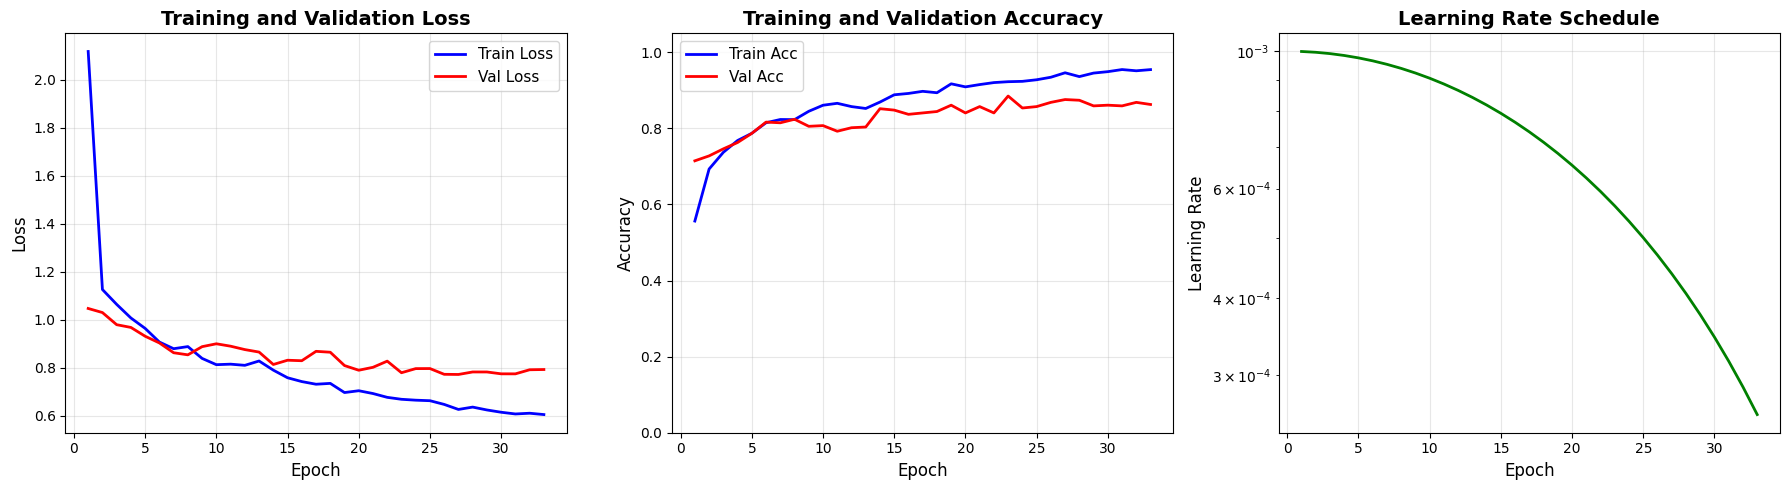


💾 Saving model to MLflow...


2025/11/16 15:54:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-19a89-9eda0-5/tmpdjipbttb/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2025/11/16 15:54:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/10 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19a89-9eda0-5/tmpdjipbttb/model/data/model.pth:   0%|          | 0…

✓ Model saved: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_frozen_v100_16gb_VALAUG1.pth
✓ MLflow run: c19f8bb63c384db880eb93a41f26f3e5

✓ DINOV3 TRAINING COMPLETE

Final Training Accuracy: 0.9546
Final Validation Accuracy: 0.8630
Best Validation Accuracy: 0.8852


<Figure size 640x480 with 0 Axes>

In [0]:
print("\n" + "="*60)
print("MODULE 10: TRAIN DINOV3 CLASSIFIER")
print("="*60)

# Setup MLflow experiment
experiment_name = "/Users/" + spark.sql("SELECT current_user()").collect()[0][0] + "/cow_behavior_dinov3_frozen"

try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"✓ Created new experiment: {experiment_name}")
    else:
        experiment_id = experiment.experiment_id
        print(f"✓ Found existing experiment: {experiment_name}")
except Exception as e:
    print(f"Error: {e}")
    experiment_name = "/Shared/cow_behavior_dinov3_frozen"
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"✓ Created experiment at: {experiment_name}")

mlflow.set_experiment(experiment_name)
DINOv3TrainingConfig.EXPERIMENT_NAME = experiment_name

print(f"\n✓ MLflow experiment ready: {experiment_name}")

# ============================================================================
# TRAIN DINOV3 MODEL
# ============================================================================

print("\n" + "="*60)
print("LOADING TRAIN/VAL SPLITS (FROM APPROACH 1)")
print("="*60)

train_split_df = pd.read_csv(dbfs_to_local(f"{Config.OUTPUT_BASE}/train_split.csv"))
val_split_df = pd.read_csv(dbfs_to_local(f"{Config.OUTPUT_BASE}/val_split.csv"))

print(f"✓ Train split: {len(train_split_df)} samples")
print(f"✓ Val split: {len(val_split_df)} samples")

# Create data loaders with REDUCED batch size
print("\nCreating data loaders (batch_size=8 for V100 16GB)...")
dataloaders = create_dataloaders(
    train_df=train_split_df,
    val_df=val_split_df,
    test_df=None,
    batch_size=DINOv3TrainingConfig.BATCH_SIZE,  # 8 instead of 32
    num_workers=DINOv3TrainingConfig.NUM_WORKERS,
    image_size=DINOv3TrainingConfig.IMAGE_SIZE,
    use_weighted_sampling=DINOv3TrainingConfig.USE_WEIGHTED_SAMPLING,
    augmentation_strength=DINOv3TrainingConfig.AUGMENTATION_STRENGTH,
    augmentation_multiplier=DINOv3TrainingConfig.AUGMENTATION_MULTIPLIER,
    val_augmentation_multiplier=DINOv3TrainingConfig.VAL_AUGMENTATION_MULTIPLIER
)

print(f"\n✓ Train loader: {len(dataloaders['train'].dataset)} effective samples")
print(f"  (Batches per epoch: {len(dataloaders['train'])})")
print(f"✓ Val loader: {len(dataloaders['val'].dataset)} samples")

# Create model
print("\nCreating DINOv3 + Classifier...")
print("⏳ Loading 6.7B parameter model (5-10 minutes)...")

model = DINOv3WithClassifier(
    num_classes=DINOv3TrainingConfig.NUM_CLASSES,
    hidden_dim=DINOv3TrainingConfig.HIDDEN_DIM,
    dropout_rate=DINOv3TrainingConfig.DROPOUT_RATE
)

total_params, trainable_params = count_parameters(model)
print(f"\n✓ Model created")
print(f"  - Total: {total_params:,} ({total_params/1e9:.2f}B)")
print(f"  - Trainable: {trainable_params:,} ({trainable_params/1e6:.2f}M)")
print(f"  - Efficiency: {100 * trainable_params / total_params:.3f}%")

# Start MLflow run
with mlflow.start_run(run_name=f"dinov3_frozen_v100_16gb_VALAUG1_{int(time.time())}") as run:
    print(f"\n{'='*60}")
    print(f"MLflow Run ID: {run.info.run_id}")
    print(f"{'='*60}")
    
    # Log parameters
    mlflow.log_params({
        'model_name': DINOv3TrainingConfig.MODEL_NAME,
        'dinov3_model': 'facebook/dinov3-vit7b16-pretrain-lvd1689m',
        'gpu': 'V100_16GB',
        'optimization': 'gradient_accumulation+amp+fp16',
        'batch_size': DINOv3TrainingConfig.BATCH_SIZE,
        'gradient_accumulation_steps': DINOv3TrainingConfig.GRADIENT_ACCUMULATION_STEPS,
        'effective_batch_size': DINOv3TrainingConfig.BATCH_SIZE * DINOv3TrainingConfig.GRADIENT_ACCUMULATION_STEPS,
        'mixed_precision': DINOv3TrainingConfig.USE_MIXED_PRECISION,
        'num_classes': DINOv3TrainingConfig.NUM_CLASSES,
        'hidden_dim': DINOv3TrainingConfig.HIDDEN_DIM,
        'dropout_rate': DINOv3TrainingConfig.DROPOUT_RATE,
        'epochs': DINOv3TrainingConfig.EPOCHS,
        'learning_rate': DINOv3TrainingConfig.LEARNING_RATE,
        'weight_decay': DINOv3TrainingConfig.WEIGHT_DECAY,
        'scheduler': DINOv3TrainingConfig.SCHEDULER_TYPE,
        'augmentation': DINOv3TrainingConfig.AUGMENTATION_STRENGTH,
        'augmentation_multiplier': DINOv3TrainingConfig.AUGMENTATION_MULTIPLIER,
        'label_smoothing': DINOv3TrainingConfig.LABEL_SMOOTHING,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'train_samples': len(train_split_df),
        'val_samples': len(val_split_df)
    })
    
    # Create trainer
    trainer = DINOv3Trainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],
        config=DINOv3TrainingConfig
    )
    
    # Train
    history = trainer.train()
    
    # Plot history
    print("\n📊 Plotting training history...")
    plot_training_history(history)
    
    # Save plot
    fig_path = "/tmp/dinov3_v100_16gb_training_history.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(fig_path, "plots")
    
    # Log final metrics
    mlflow.log_metrics({
        'final_train_loss': history['train_loss'][-1],
        'final_train_acc': history['train_acc'][-1],
        'final_val_loss': history['val_loss'][-1],
        'final_val_acc': history['val_acc'][-1],
        'best_val_acc': max(history['val_acc']),
        'total_epochs': len(history['train_loss'])
    })
    
    # Log model
    print("\n💾 Saving model to MLflow...")
    mlflow.pytorch.log_model(model, "model")
    
    # Save model locally
    model_save_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/dinov3_frozen_v100_16gb_VALAUG1.pth")
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save({
        'classifier_state_dict': model.classifier.state_dict(),
        'history': history,
        'config': {
            'model_name': DINOv3TrainingConfig.MODEL_NAME,
            'num_classes': DINOv3TrainingConfig.NUM_CLASSES,
            'hidden_dim': DINOv3TrainingConfig.HIDDEN_DIM,
            'dropout_rate': DINOv3TrainingConfig.DROPOUT_RATE,
            'embedding_dim': model.num_features,
            'best_val_acc': max(history['val_acc']),
            'optimizations': 'V100_16GB+grad_accum+amp+fp16'
        }
    }, model_save_path)
    
    print(f"✓ Model saved: {local_to_dbfs(model_save_path)}")
    print(f"✓ MLflow run: {run.info.run_id}")

print("\n" + "="*60)
print("✓ DINOV3 TRAINING COMPLETE")
print("="*60)
print(f"\nFinal Training Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
print("="*60)

## MODULE 11: EVALUATION (USE SAME CODE AS STANDARD VERSION)

✓ Libraries imported
Run ID: c19f8bb63c384db880eb93a41f26f3e5
Checkpoint: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/Frozen Backbone/dinov3_frozen_v100_16gb_VALAUG1.pth

STEP 1: LOAD MODELS (DINOv3 + CLASSIFIER)
Loading DINOv3 base model...


config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.01G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Loading Classifier from: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/Frozen Backbone/dinov3_frozen_v100_16gb_VALAUG1.pth
✓ Models loaded successfully

STEP 2: SETUP PARALLEL INFERENCE
✓ Using single GPU: Tesla V100-PCIE-16GB
✓ Models moved to cuda

STEP 3: CREATE TEST DATASET
✓ Test dataset: 211800 samples
✓ Batch size: 16

STEP 4: RUN INFERENCE
Processing 13238 batches...


Evaluating:   3%|▎         

*** WARNING: max output size exceeded, skipping output. ***

Evaluating: 100%|██████████| 13238/13238 [8:50:48<00:00,  2.41s/it]


✓ Inference complete: 31848.2s

STEP 5: OVERALL RESULTS
Accuracy:  0.7656
F1-Score:  0.7691

STEP 6: DETAILED REPORT
                   precision    recall  f1-score   support

         Drinking     0.4355    0.7137    0.5410      3011
Feeding head down     0.8705    0.2943    0.4399     30952
  Feeding head up     0.5100    0.5478    0.5282     18783
            Lying     0.9579    0.9898    0.9736     83509
         Standing     0.7782    0.7826    0.7804     69807
          Walking     0.1151    0.5331    0.1894      3819
  frontal_pushing     0.6328    0.8417    0.7225       600
           gallop     0.7105    0.5548    0.6230       575
             leap     0.5763    0.6142    0.5947       744

         accuracy                         0.7656    211800
        macro avg     0.6208    0.6525    0.5992    211800
     weighted avg     0.8206    0.7656    0.7691    211800


STEP 7: CONFUSION MATRICES


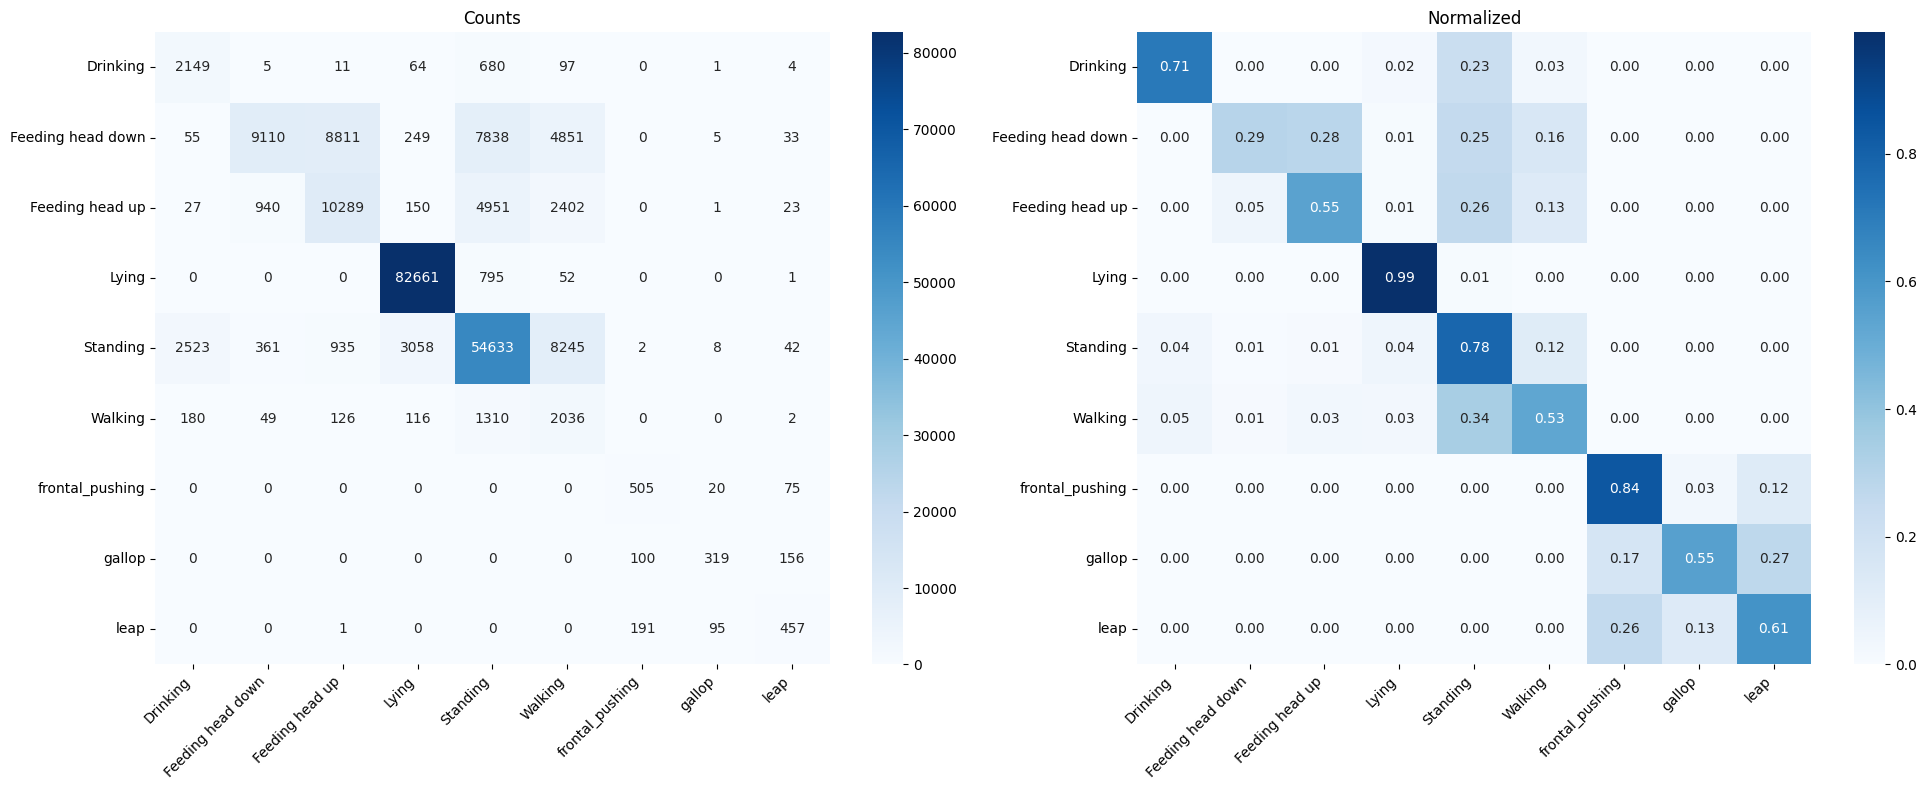

✓ Confusion matrices saved

STEP 8: PER-CLASS PERFORMANCE


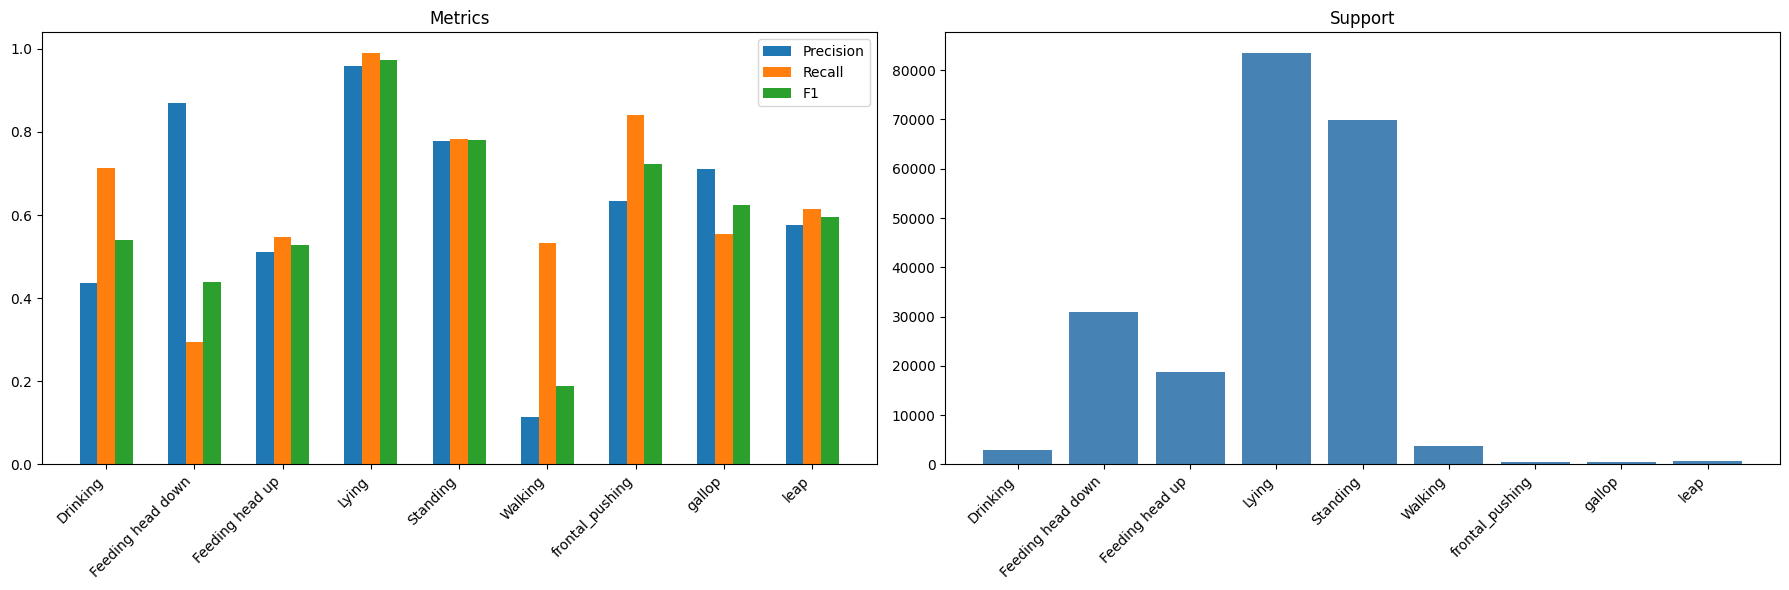

✓ Per-class plots saved

STEP 9: CONFUSION PAIRS
Top 10 Confused Pairs:
Feeding head down -> Feeding head up: 8811 (28.5%)
Standing -> Walking: 8245 (11.8%)
Feeding head down -> Standing: 7838 (25.3%)
Feeding head up -> Standing: 4951 (26.4%)
Feeding head down -> Walking: 4851 (15.7%)
Standing -> Lying: 3058 (4.4%)
Standing -> Drinking: 2523 (3.6%)
Feeding head up -> Walking: 2402 (12.8%)
Walking -> Standing: 1310 (34.3%)
Feeding head up -> Feeding head down: 940 (5.0%)


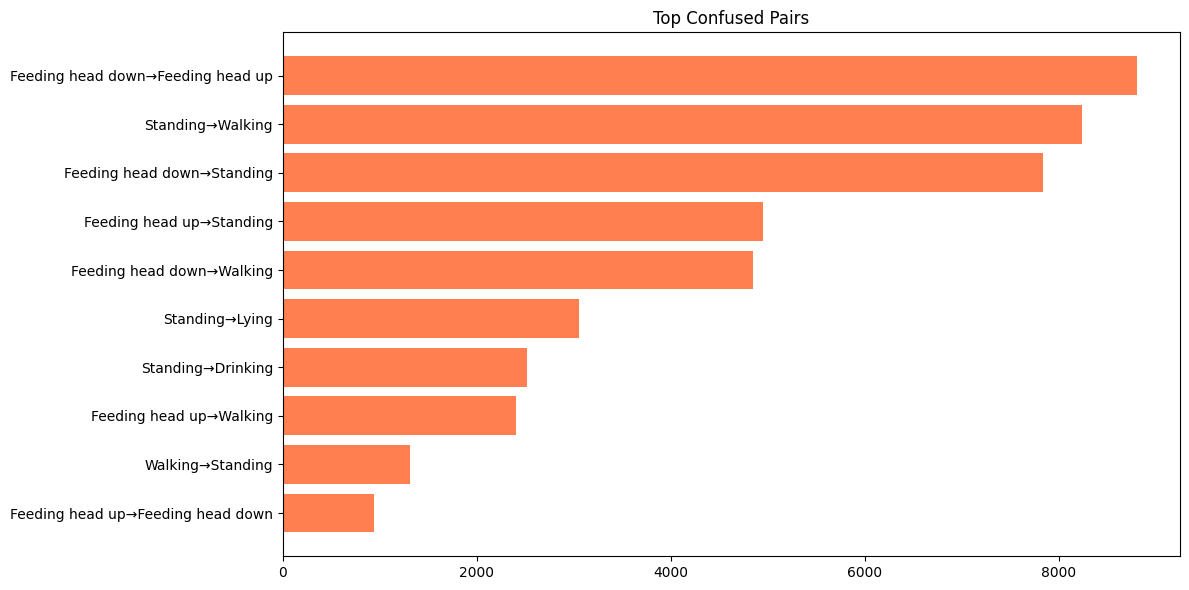


STEP 10: PERFORMANCE BY SOURCE
Source               | Acc      | F1       | Samples
------------------------------------------------------------
mmcows               | 0.7665   | 0.7703   | 209881
playbehavior         | 0.6675   | 0.6631   | 1919

STEP 11: SAVE RESULTS
✓ Results saved to: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_frozen_evalx1_results.json
✓ Predictions saved to: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_frozen_predictions_evalx1.csv

STEP 12: LOG TO MLFLOW
Logging to MLflow Run: c19f8bb63c384db880eb93a41f26f3e5
🏃 View run dinov3_frozen_v100_16gb_VALAUG1_1763245708 at: https://adb-65044996157806.6.azuredatabricks.net/ml/experiments/732862339525847/runs/c19f8bb63c384db880eb93a41f26f3e5
🧪 View experiment at: https://adb-65044996157806.6.azuredatabricks.net/ml/experiments/732862339525847
✓ Successfully logged to MLflow

✅ EVALUATION COMPLETE


In [0]:
# ============================================================================
# MODULE 12 (FROZEN VARIANT): 12-STEP COMPREHENSIVE EVALUATION
# STRUCTURE MATCHES "CODE 3" EXACTLY FOR CONSISTENCY
# ============================================================================

import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report
)
import mlflow
import mlflow.pytorch
from transformers import AutoModel

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✓ Libraries imported")

# ============================================================================
# CONFIGURATION
# ============================================================================

# ----------------------------------------------------------------------------
# [USER INPUT REQUIRED]
# ----------------------------------------------------------------------------
RUN_ID = "c19f8bb63c384db880eb93a41f26f3e5"  # <--- PASTE RUN ID HERE

# Path to the specific checkpoint (Frozen classifier weights)
CHECKPOINT_PATH = dbfs_to_local(f"{Config.OUTPUT_BASE}/Frozen Backbone/dinov3_frozen_v100_16gb_VALAUG1.pth") 

print(f"Run ID: {RUN_ID}")
print(f"Checkpoint: {CHECKPOINT_PATH}")
# ----------------------------------------------------------------------------


# ============================================================================
# DATASET CLASS (WITH METADATA)
# ============================================================================

class AdvancedTestDataset(Dataset):
    def __init__(self, df, label_to_idx):
        self.df = df.reset_index(drop=True)
        self.label_to_idx = label_to_idx
        self.idx_to_label = {v: k for k, v in label_to_idx.items()}
        self.transform = AugmentationPipeline(image_size=224, mode='test')
        self._failed = set()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if idx in self._failed:
            idx = np.random.randint(0, len(self))
        try:
            row = self.df.iloc[idx]
            image = load_image_cv2(row['image_path'])
            if image is None:
                self._failed.add(idx)
                return self.__getitem__(np.random.randint(0, len(self)))
            
            label_idx = self.label_to_idx[row['label']]
            image_tensor = self.transform(image)
            
            metadata = {
                'image_path': row['image_path'],
                'label_str': row['label'],
                'source': row.get('source', 'unknown')
            }
            return image_tensor, label_idx, metadata
        except:
            self._failed.add(idx)
            return self.__getitem__(np.random.randint(0, len(self)))


# ============================================================================
# STEP 1: LOAD MODELS
# ============================================================================

print("\n" + "="*60)
print("STEP 1: LOAD MODELS (DINOv3 + CLASSIFIER)")
print("="*60)

# 1. Load Base DINOv3
print("Loading DINOv3 base model...")
dinov3_model_name = "facebook/dinov3-vit7b16-pretrain-lvd1689m"
base_model = AutoModel.from_pretrained(
    dinov3_model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)
base_model.eval()

# 2. Load Classifier
print(f"Loading Classifier from: {CHECKPOINT_PATH}")
checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')

class StandaloneClassifier(nn.Module):
    def __init__(self, embedding_dim=4096, num_classes=9, hidden_dim=1024, dropout_rate=0.3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    def forward(self, embeddings):
        return self.classifier(embeddings)

classifier = StandaloneClassifier(
    num_classes=checkpoint['config']['num_classes'],
    hidden_dim=checkpoint['config']['hidden_dim'],
    dropout_rate=checkpoint['config']['dropout_rate']
)
classifier.load_state_dict(checkpoint['classifier_state_dict'])
classifier.eval()

print("✓ Models loaded successfully")


# ============================================================================
# STEP 2: SETUP PARALLEL INFERENCE
# ============================================================================

print("\n" + "="*60)
print("STEP 2: SETUP PARALLEL INFERENCE")
print("="*60)

num_gpus = torch.cuda.device_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if num_gpus > 1:
    print(f"✓ Detected {num_gpus} GPUs - enabling DataParallel for DINOv3")
    # Wrap the heavy base model
    base_model = nn.DataParallel(base_model)
else:
    print(f"✓ Using single GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Ensure models are on correct device
# Note: If DataParallel is used, base_model is already on cuda
if not isinstance(base_model, nn.DataParallel):
    base_model = base_model.to(device)
    
classifier = classifier.to(device)

print(f"✓ Models moved to {device}")


# ============================================================================
# STEP 3: CREATE TEST DATASET
# ============================================================================

print("\n" + "="*60)
print("STEP 3: CREATE TEST DATASET")
print("="*60)

all_labels = sorted(Config.ALL_LABELS)
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

test_dataset = AdvancedTestDataset(combined_test_df, label_to_idx)

# Batch size logic
batch_size = 16 * num_gpus if num_gpus > 0 else 16

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✓ Test dataset: {len(test_dataset)} samples")
print(f"✓ Batch size: {batch_size}")


# ============================================================================
# STEP 4: RUN INFERENCE
# ============================================================================

print("\n" + "="*60)
print("STEP 4: RUN INFERENCE")
print("="*60)

all_preds = []
all_labels_list = []
all_metadata = []

print(f"Processing {len(test_loader)} batches...")
start_time = time.time()

with torch.no_grad():
    for images, labels, metadata_batch in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        
        # Denormalize for DINOv3
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
        images_denorm = images * std + mean
        images_denorm = torch.clamp(images_denorm, 0, 1)
        
        # Forward Pass
        with torch.cuda.amp.autocast():
            # 1. Get Embeddings
            if isinstance(base_model, nn.DataParallel):
                # DataParallel wrapper handles the forward call slightly differently usually
                outputs = base_model(pixel_values=images_denorm)
                embeddings = outputs.pooler_output
            else:
                outputs = base_model(pixel_values=images_denorm)
                embeddings = outputs.pooler_output
            
            # 2. Classify
            logits = classifier(embeddings.float())
        
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels_list.extend(labels.numpy())
        
        # Metadata
        batch_len = len(labels)
        for i in range(batch_len):
            all_metadata.append({
                'image_path': metadata_batch['image_path'][i],
                'label_str': metadata_batch['label_str'][i],
                'source': metadata_batch['source'][i]
            })

eval_time = time.time() - start_time
print(f"✓ Inference complete: {eval_time:.1f}s")

# Cleanup heavy model to save memory for plotting
del base_model
torch.cuda.empty_cache()


# ============================================================================
# STEP 5: CALCULATE METRICS
# ============================================================================

print("\n" + "="*60)
print("STEP 5: OVERALL RESULTS")
print("="*60)

accuracy = accuracy_score(all_labels_list, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels_list, all_preds, average='weighted'
)
target_names = [idx_to_label[i] for i in range(len(label_to_idx))]

print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")


# ============================================================================
# STEP 6: DETAILED CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*60)
print("STEP 6: DETAILED REPORT")
print("="*60)

print(classification_report(all_labels_list, all_preds, target_names=target_names, digits=4))


# ============================================================================
# STEP 7: CONFUSION MATRICES
# ============================================================================

print("\n" + "="*60)
print("STEP 7: CONFUSION MATRICES")
print("="*60)

cm = confusion_matrix(all_labels_list, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Counts')
axes[0].set_xticklabels(target_names, rotation=45, ha='right')

# Normalized
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Normalized')
axes[1].set_xticklabels(target_names, rotation=45, ha='right')

plt.tight_layout()
cm_save_path = '/tmp/dinov3_frozen_confusion_matrix.png'
plt.savefig(cm_save_path, dpi=300)
plt.show()
print("✓ Confusion matrices saved")


# ============================================================================
# STEP 8: PER-CLASS PERFORMANCE
# ============================================================================

print("\n" + "="*60)
print("STEP 8: PER-CLASS PERFORMANCE")
print("="*60)

p, r, f, s = precision_recall_fscore_support(all_labels_list, all_preds, average=None)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
x = np.arange(len(target_names))

# Metrics
axes[0].bar(x-0.2, p, 0.2, label='Precision')
axes[0].bar(x, r, 0.2, label='Recall')
axes[0].bar(x+0.2, f, 0.2, label='F1')
axes[0].set_xticks(x)
axes[0].set_xticklabels(target_names, rotation=45, ha='right')
axes[0].legend()
axes[0].set_title('Metrics')

# Support
axes[1].bar(x, s, color='steelblue')
axes[1].set_xticks(x)
axes[1].set_xticklabels(target_names, rotation=45, ha='right')
axes[1].set_title('Support')

plt.tight_layout()
perf_save_path = '/tmp/dinov3_frozen_per_class.png'
plt.savefig(perf_save_path, dpi=300)
plt.show()
print("✓ Per-class plots saved")


# ============================================================================
# STEP 9: CONFUSION PAIR ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("STEP 9: CONFUSION PAIRS")
print("="*60)

pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            pairs.append({
                'true': target_names[i], 'pred': target_names[j],
                'count': cm[i, j], 'pct': cm[i, j] / cm[i].sum() * 100
            })
pairs.sort(key=lambda x: x['count'], reverse=True)

print("Top 10 Confused Pairs:")
for pair in pairs[:10]:
    print(f"{pair['true']} -> {pair['pred']}: {pair['count']} ({pair['pct']:.1f}%)")

# Plot
if pairs:
    top_pairs = pairs[:10]
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = [f"{p['true']}→{p['pred']}" for p in top_pairs]
    counts = [p['count'] for p in top_pairs]
    ax.barh(labels, counts, color='coral')
    ax.invert_yaxis()
    ax.set_title('Top Confused Pairs')
    plt.tight_layout()
    pairs_save_path = '/tmp/dinov3_frozen_confusion_pairs.png'
    plt.savefig(pairs_save_path, dpi=300)
    plt.show()
else:
    pairs_save_path = None


# ============================================================================
# STEP 10: PERFORMANCE BY SOURCE
# ============================================================================

print("\n" + "="*60)
print("STEP 10: PERFORMANCE BY SOURCE")
print("="*60)

sources = [m['source'] for m in all_metadata]
unique_sources = sorted(set(sources))
source_metrics = {}

print(f"{'Source':<20s} | {'Acc':<8s} | {'F1':<8s} | {'Samples'}")
print("-" * 60)

for source in unique_sources:
    mask = [s == source for s in sources]
    s_labels = [l for l, m in zip(all_labels_list, mask) if m]
    s_preds = [p for p, m in zip(all_preds, mask) if m]
    
    if s_labels:
        s_acc = accuracy_score(s_labels, s_preds)
        _, _, s_f1, _ = precision_recall_fscore_support(s_labels, s_preds, average='weighted', zero_division=0)
        source_metrics[source] = {'accuracy': s_acc, 'f1': s_f1, 'samples': len(s_labels)}
        print(f"{source:<20s} | {s_acc:<8.4f} | {s_f1:<8.4f} | {len(s_labels)}")


# ============================================================================
# STEP 11: SAVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("STEP 11: SAVE RESULTS")
print("="*60)

# 1. JSON
results = {
    'model': 'dinov3_frozen_v100',
    'run_id': RUN_ID,
    'accuracy': float(accuracy),
    'f1': float(f1),
    'per_source': source_metrics,
    'per_class': {
        target_names[i]: {'p': float(p[i]), 'r': float(r[i]), 'f': float(f[i]), 's': int(s[i])} 
        for i in range(len(target_names))
    }
}
results_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/dinov3_frozen_evalx1_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# 2. CSV
pred_df = pd.DataFrame({
    'image_path': [m['image_path'] for m in all_metadata],
    'true_label': [idx_to_label[l] for l in all_labels_list],
    'pred_label': [idx_to_label[p] for p in all_preds],
    'correct': [l == p for l, p in zip(all_labels_list, all_preds)],
    'source': [m['source'] for m in all_metadata]
})
csv_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/dinov3_frozen_predictions_evalx1.csv")
pred_df.to_csv(csv_path, index=False)

print(f"✓ Results saved to: {local_to_dbfs(results_path)}")
print(f"✓ Predictions saved to: {local_to_dbfs(csv_path)}")


# ============================================================================
# STEP 12: LOG TO MLFLOW
# ============================================================================

print("\n" + "="*60)
print("STEP 12: LOG TO MLFLOW")
print("="*60)

if RUN_ID != "REPLACE_WITH_YOUR_RUN_ID":
    print(f"Logging to MLflow Run: {RUN_ID}")
    try:
        with mlflow.start_run(run_id=RUN_ID):
            mlflow.log_metrics({
                'test_accuracy': accuracy, 
                'test_f1': f1,
                'inference_time': eval_time
            })
            
            mlflow.log_artifact(cm_save_path, "test_results")
            mlflow.log_artifact(perf_save_path, "test_results")
            if pairs_save_path:
                mlflow.log_artifact(pairs_save_path, "test_results")
            mlflow.log_artifact(results_path, "test_results")
            mlflow.log_artifact(csv_path, "test_results")
            
        print("✓ Successfully logged to MLflow")
    except Exception as e:
        print(f"⚠️ MLflow Error: {e}")
else:
    print("⚠️ Skipping MLflow logging (No Run ID)")

print("\n✅ EVALUATION COMPLETE")